# Computational graphs in Rockpool

Graphs is Rockpool are used to convert the structure of an arbitrary network to deploy on neuromorphic hardware. The graphs cannot be used for simulation, and are generally more constrained than networks used for training and simulation.

In [1]:
# - Switch off warnings
import warnings

warnings.filterwarnings("ignore")

## Graph base classes

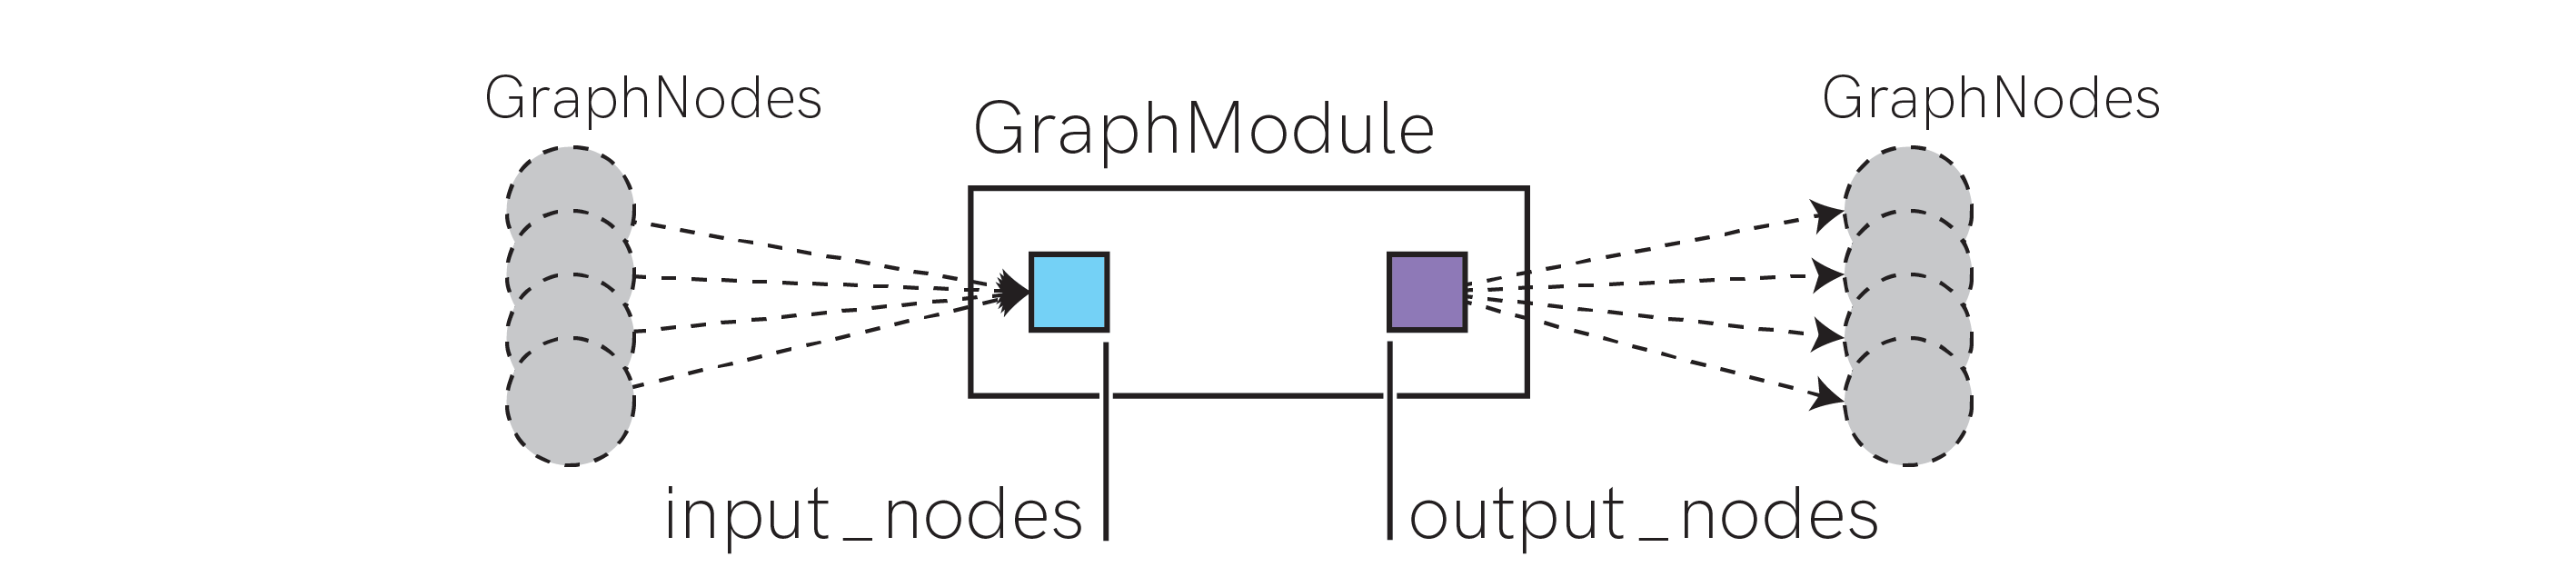

In [2]:
from IPython.display import Image
from pathlib import Path

Image(Path("images", "GraphModule.png"))

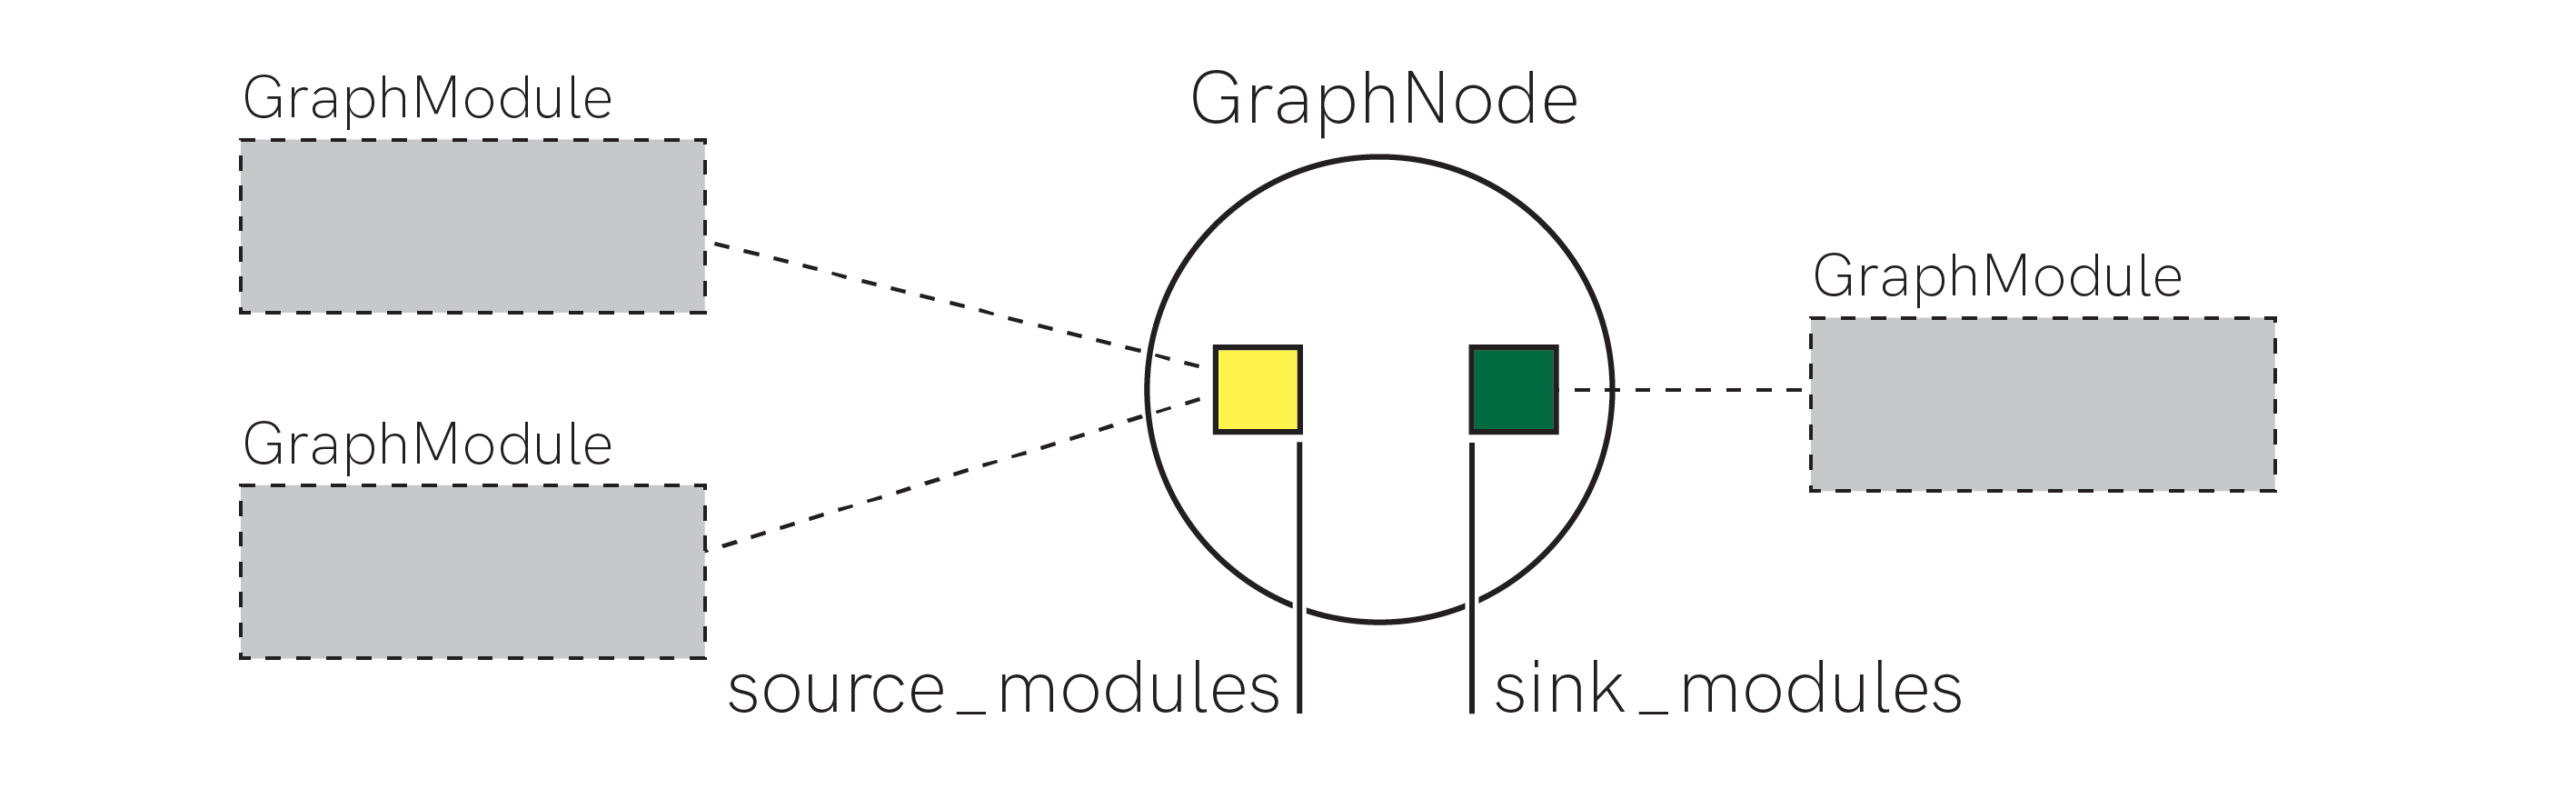

In [3]:
Image(Path("images", "GraphNode.png"))

## Building graphs

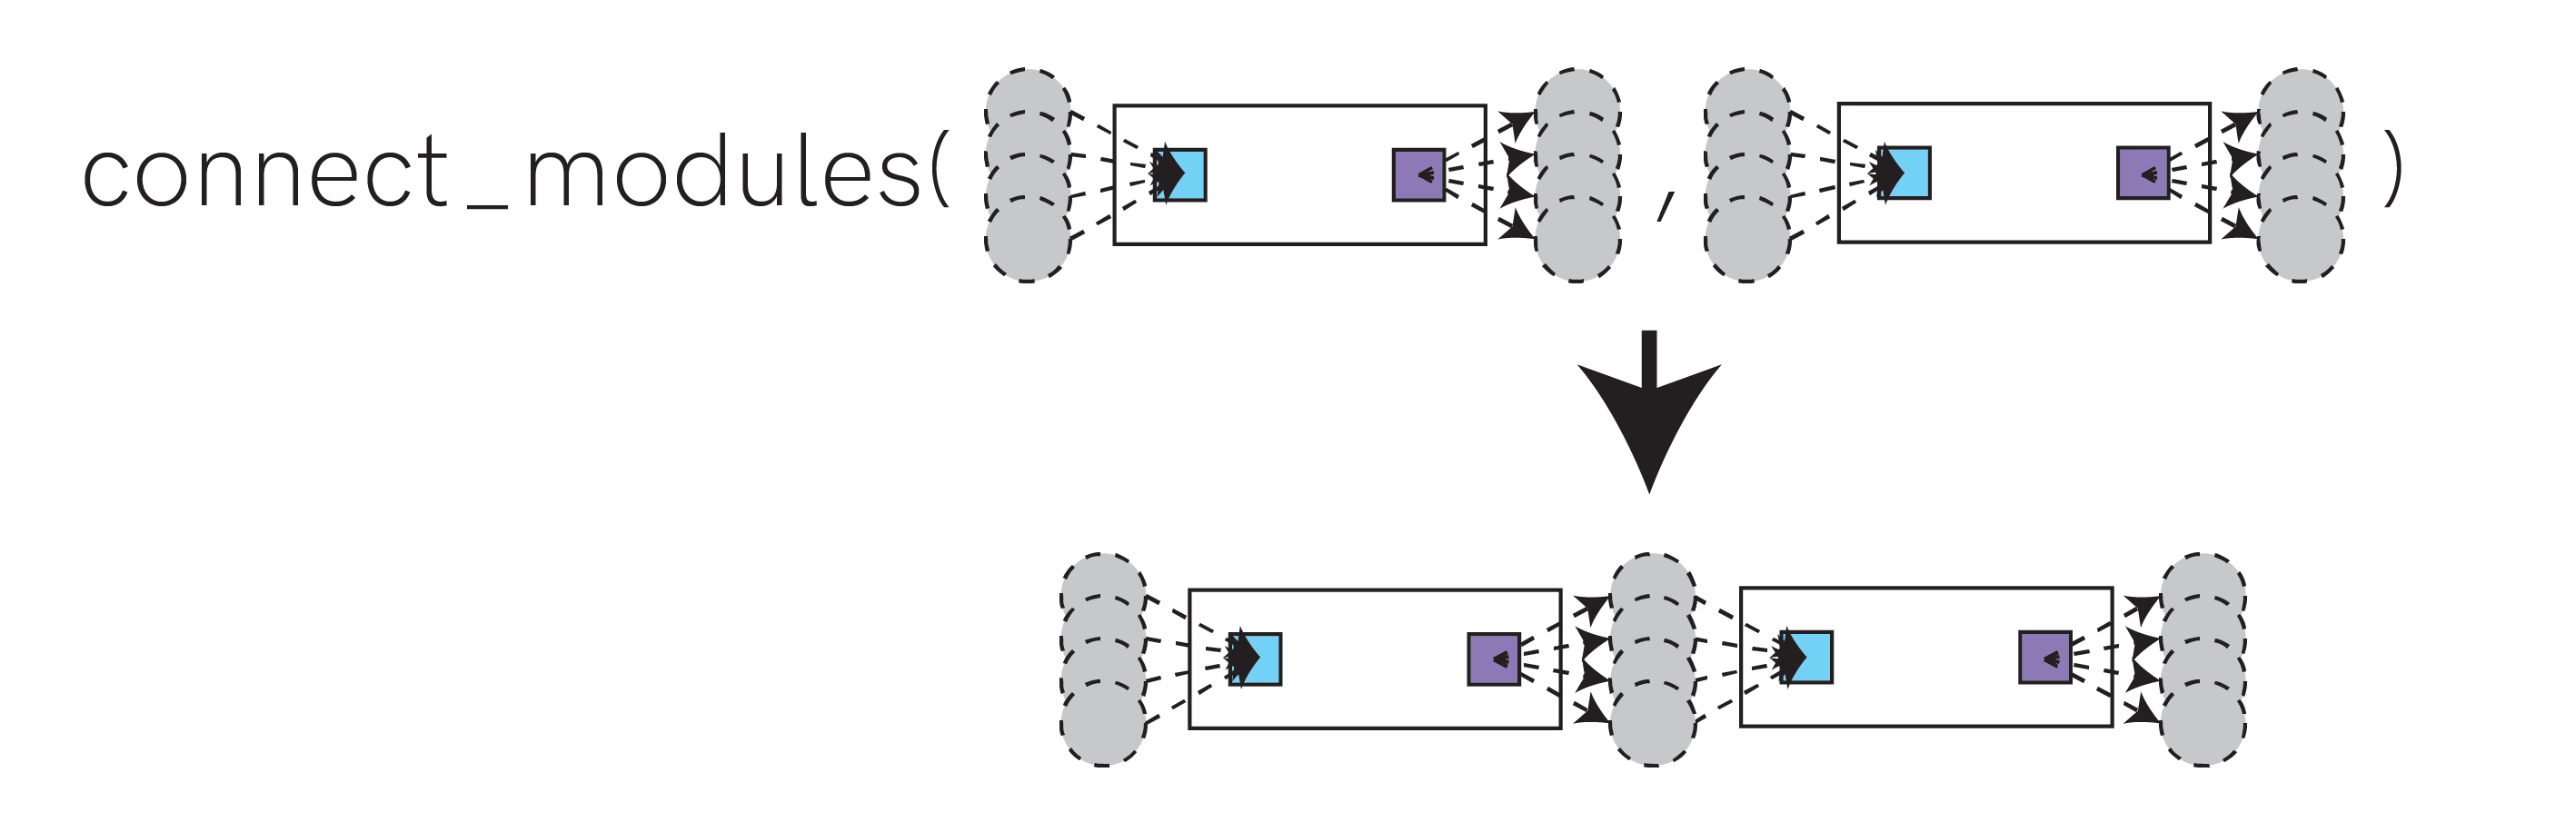

In [4]:
Image(Path("images", "connect.png"))

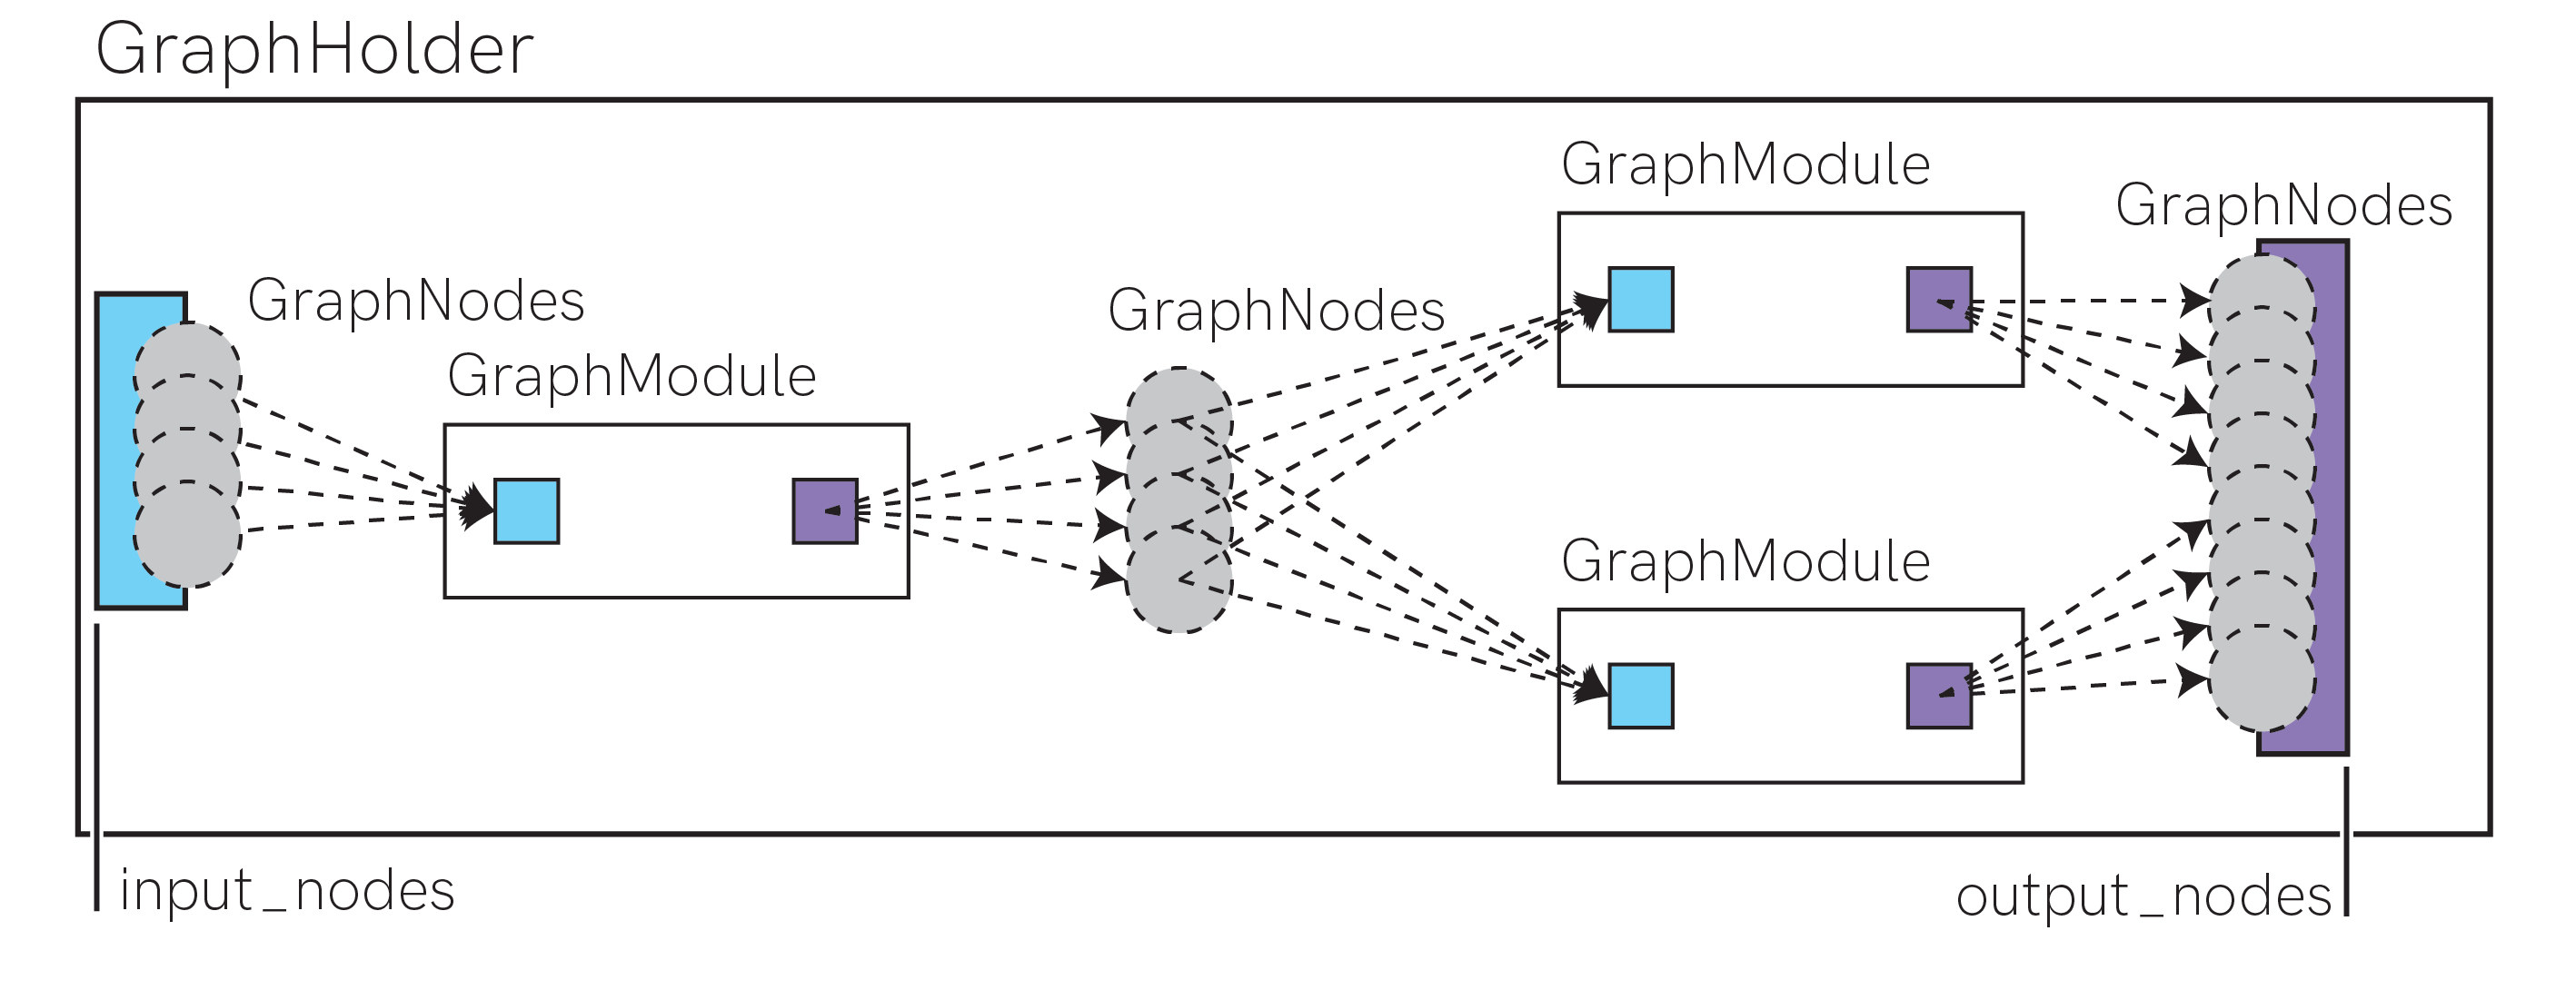

In [5]:
Image(Path("images", "GraphHolder.png"))

## Exploring graphs

In [6]:
import rockpool.graph as rg

mod1 = rg.GraphModule._factory(1, 2, "Mod1")
mod2 = rg.GraphModule._factory(2, 1, "Mod2")
rg.connect_modules(mod1, mod2)
graph = rg.GraphHolder(mod1.input_nodes, mod2.output_nodes, "Graph", None)
graph

GraphHolder "Graph" with 1 input nodes -> 1 output nodes

In [7]:
graph.input_nodes[0]

GraphNode 4461578656 with 0 source modules and 1 sink modules

In [8]:
graph.input_nodes[0].sink_modules[0]

GraphModule "Mod1" with 1 input nodes -> 2 output nodes

In [9]:
graph.input_nodes[0].sink_modules[0].output_nodes[0]

GraphNode 4461584544 with 1 source modules and 1 sink modules

In [10]:
graph.input_nodes[0].sink_modules[0].output_nodes[0].sink_modules[0]

GraphModule "Mod2" with 2 input nodes -> 1 output nodes

### Bags of graphs

In [11]:
rg.bag_graph(graph)

([GraphNode 4461578656 with 0 source modules and 1 sink modules,
  GraphNode 4461580192 with 1 source modules and 0 sink modules,
  GraphNode 4461584544 with 1 source modules and 1 sink modules,
  GraphNode 4461577792 with 1 source modules and 1 sink modules],
 [GraphModule "Mod1" with 1 input nodes -> 2 output nodes,
  GraphModule "Mod2" with 2 input nodes -> 1 output nodes])

### Searching by module class

In [12]:
import rockpool.graph as rg
import numpy as np

lin = rg.LinearWeights._factory(1, 2, "Lin", None, np.zeros((1, 2)))
rate = rg.RateNeuronWithSynsRealValue._factory(2, 2, "Rate")
rg.connect_modules(lin, rate)
graph = rg.GraphHolder(lin.input_nodes, rate.output_nodes, "Graph", None)

print(rg.find_modules_of_subclass(graph, rg.LinearWeights))
print(rg.find_modules_of_subclass(graph, rg.RateNeuronWithSynsRealValue))

[LinearWeights "Lin" with 1 input nodes -> 2 output nodes]
[RateNeuronWithSynsRealValue "Rate" with 2 input nodes -> 2 output nodes]


### Searching for recurrent modules

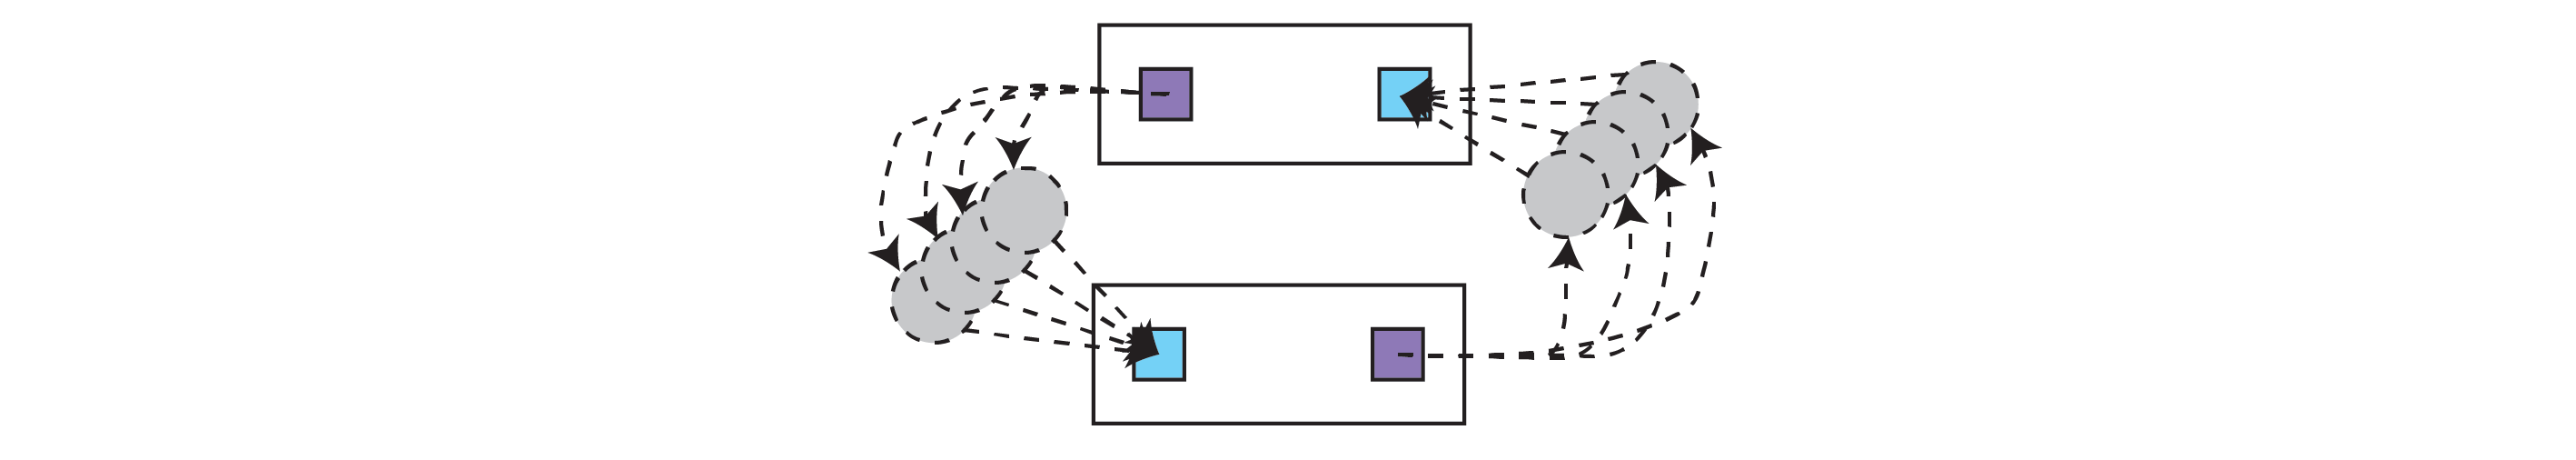

In [13]:
Image(Path("images", "recurrent_modules.png"))

In [14]:
import rockpool.graph as rg

rec_mod1 = rg.GraphModule._factory(2, 2, "Recurrent 1")

# - Use the existing graph nodes to directly connect the two modules recurrently
rec_mod2 = rg.GraphModule(
    rec_mod1.output_nodes,
    rec_mod1.input_nodes,
    "Recurrent 2",
    None,
)
graph = rg.GraphHolder(rec_mod1.input_nodes, rec_mod2.output_nodes, "Graph", None)

rg.find_recurrent_modules(graph)

[GraphModule "Recurrent 2" with 2 input nodes -> 2 output nodes,
 GraphModule "Recurrent 1" with 2 input nodes -> 2 output nodes]

## Integrating custom `nn.Module` s into the computational graph

In [15]:
import rockpool.graph as rg
from rockpool.nn.modules import LIFTorch


class MyLIFNeuron(LIFTorch):
    def as_graph(self) -> rg.GraphModuleBase:
        return rg.LIFNeuronWithSynsRealValue._factory(
            size_in=self.size_in,
            size_out=self.size_out,
            name=self.name,
            computational_module=self,
            tau_mem=self.tau_mem,
            tau_syn=self.tau_syn,
            bias=self.bias,
            dt=self.dt,
        )


mod = MyLIFNeuron(4)
mod.as_graph()

Could not import package: No module named 'iaf_nest'


LIFNeuronWithSynsRealValue with 4 input nodes -> 4 output nodes

In [16]:
from rockpool.nn.modules import Linear, Rate, Module
import rockpool.graph as rg


class WeightedRate(Module):
    def __init__(self, shape: tuple, *args, **kwargs):
        # - Initialise superclass
        super().__init__(shape, *args, **kwargs)

        # - Define two sub-modules
        self.lin = Linear(shape[0:2])
        self.rate = Rate(shape[1])

    def evolve(self, input_data, record: bool = False):
        # - Push data through the sub-modules
        out, ns_lin, rd_lin = self.lin(input_data, record)
        out, ns_rate, rd_rate = self.rate(out, record)

        ns = dict("lin", ns_lin, "rate", ns_rate)
        rd = dict("lin", rd_lin, "rate", rd_rate)

        return out, ns, rd

In [17]:
class WeightedRate(WeightedRate):
    def as_graph(self) -> rg.GraphModuleBase:
        # - Get a graph module for the two sub-modules
        glin = self.lin.as_graph()
        grate = self.rate.as_graph()

        # - Connnect the two modules
        rg.connect_modules(glin, grate)

        # - Return a graph holder
        return rg.GraphHolder(glin.input_nodes, grate.output_nodes, self.name, self)

In [18]:
mod = WeightedRate((1, 2))
mod.as_graph()

GraphHolder with 1 input nodes -> 2 output nodes

## Next steps